In [93]:
# 1. Imports & Configuration Initiale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import os
import random
from itertools import combinations
from datetime import datetime

# Pour la reproductibilité (fixer les seeds)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [94]:
# Charger les données prétraitées
df = pd.read_csv("../data/Customers_cleaned.csv")

In [95]:
%load_ext tensorboard

In [96]:
# Suppression de la colonne 'customerID' 
df = df.drop(columns=['customerID'])

# Encodage de la variable cible 'Churn' (transformation en 0 et 1)
df['Churn'] = (df['Churn'].str.lower().str.strip() == 'yes').astype(int)

# Features candidates à supprimer (celles que je veux tester)
features_candidates = [
    'gender', 'PhoneService', 'StreamingMovies', 'StreamingTV',
    'DeviceProtection', 'OnlineBackup', 'MultipleLines'
]

# Liste des caractéristiques à toujours supprimer (ici, seulement la cible après encodage)
always_drop = ['Churn']

In [97]:
# 4. Division des données en ensembles d'entraînement, de validation et de test
# Split initial en train+validation et test
X, X_test, y, y_test = train_test_split(
    df.drop(columns=['Churn']), df['Churn'], test_size=0.2, random_state=SEED, stratify=df['Churn']
)

# Split de l'ensemble train+validation en train et validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y  # 0.25 * 0.8 = 0.2 (20% pour validation)
)

In [98]:
# Initialisation d'une liste pour stocker les résultats de chaque combinaison de features
results = []

# 5. Boucle principale : Test de toutes les combinaisons de suppressions de features
for r in range(len(features_candidates) + 1): # Boucle sur le nombre de features à supprimer (0 à len(features_candidates))
    for combo in combinations(features_candidates, r): # Génère toutes les combinaisons possibles de features à supprimer
        additional_features_to_drop = list(combo) # Convertit la combinaison en liste
        features_to_drop = always_drop + additional_features_to_drop # Liste complète des features à supprimer pour cette itération

        # Création d'une copie des DataFrames pour éviter de modifier l'original
        X_train_copy = X_train.copy()
        X_val_copy = X_val.copy()

        # Suppression des features
        X_train_subset = X_train_copy.drop(columns=additional_features_to_drop, errors='ignore')
        X_val_subset = X_val_copy.drop(columns=additional_features_to_drop, errors='ignore')

        # Identification des colonnes numériques et catégorielles
        numeric_features = X_train_subset.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X_train_subset.select_dtypes(include=['object']).columns.tolist()

        # Définition du pipeline de pré-traitement des données
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features), # Standardisation des variables numériques
                ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features) # Encodage One-Hot des variables catégorielles
            ],
            remainder='passthrough'  # Gérer les colonnes non spécifiées
        )

        # Application du pré-traitement : fit et transform sur l'ensemble d'entraînement, transform seulement sur l'ensemble de validation
        X_train_prep = preprocessor.fit_transform(X_train_subset)
        X_val_prep = preprocessor.transform(X_val_subset)

        # ----------------------------------------------------------------------
        # 6. Construction du MLP (Multi-Layer Perceptron) avec Keras
        input_dim = X_train_prep.shape[1] # Détermination de la dimension de l'entrée du modèle
        lr = 0.001 # Taux d'apprentissage
        dropout = 0.3 # Taux de dropout

        # Définition de l'architecture du modèle
        model = keras.Sequential([
            layers.Input(shape=(input_dim,), name='tabular_input'), # Couche d'entrée
            layers.Dense(128, activation='relu'), # Couche Dense (entièrement connectée) avec activation ReLU
            layers.Dropout(dropout), # Couche de Dropout pour réduire le surapprentissage
            layers.Dense(64, activation='relu'), # Couche Dense avec activation ReLU
            layers.Dropout(dropout), # Couche de Dropout
            layers.Dense(1, activation='sigmoid') # Couche de sortie avec activation Sigmoid (pour la classification binaire)
        ], name='telco_mlp')

        # Compilation du modèle
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr), # Optimiseur Adam
            loss='binary_crossentropy', # Fonction de perte (Binary Cross-Entropy pour la classification binaire)
            metrics=[
                keras.metrics.AUC(name='auc'), # Métrique : Aire sous la courbe ROC
                keras.metrics.Recall(name='recall'), # Métrique : Recall (Sensibilité)
                keras.metrics.Precision(name='precision') # Métrique : Précision
            ]
        )

        # 7. Callbacks & gestion du déséquilibre de classes
        run_id = f"drop_{'_'.join(additional_features_to_drop) if additional_features_to_drop else 'aucune'}_{datetime.now().strftime('%Y%m%d_%H%M%S')}" # Création d'un identifiant unique pour cette exécution
        checkpoints_dir = os.path.join("checkpoints", run_id) # Définition du répertoire pour sauvegarder les checkpoints du modèle
        tensorboard_dir = os.path.join("tensorboard_logs", run_id) # Définition du répertoire pour les logs TensorBoard
        os.makedirs(checkpoints_dir, exist_ok=True) # Création du répertoire (si inexistant)
        os.makedirs(tensorboard_dir, exist_ok=True) # Création du répertoire (si inexistant)

        # Définition des callbacks
        cb_early_stopping = callbacks.EarlyStopping(
            monitor='val_auc', # Surveille l'AUC sur l'ensemble de validation
            patience=10, # Nombre d'époques sans amélioration avant d'arrêter l'entraînement
            restore_best_weights=True, # Restaure les poids du modèle à la meilleure époque
            mode='max' # Recherche la valeur maximale de la métrique
        )
        cb_checkpoint = callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoints_dir, 'best_model.keras'), # Chemin du fichier pour sauvegarder le meilleur modèle
            monitor="val_auc", # Surveille l'AUC sur l'ensemble de validation
            save_best_only=True, # Sauvegarde seulement le meilleur modèle
            mode='max' # Recherche la valeur maximale de la métrique
        )
        cb_tensorboard = callbacks.TensorBoard(
            log_dir=tensorboard_dir, # Répertoire pour les logs TensorBoard
            histogram_freq=1 # Enregistre les histogrammes des poids et des activations à chaque époque
        )

        # Calcul des poids des classes pour gérer le déséquilibre
        neg, pos = np.bincount(y_train) # Comptage des exemples négatifs et positifs dans l'ensemble d'entraînement
        class_weight = {0: 1.0, 1: neg / pos} # Définition des poids : la classe majoritaire a un poids de 1, la classe minoritaire a un poids inversement proportionnel à sa fréquence

        # 8. Entraînement du modèle
        history = model.fit(
            X_train_prep, y_train, # Données d'entraînement
            validation_data=(X_val_prep, y_val), # Données de validation
            epochs=10, # Nombre d'époques
            batch_size=128, # Taille des batchs
            callbacks=[cb_early_stopping, cb_checkpoint, cb_tensorboard], # Callbacks
            class_weight=class_weight, # Poids des classes
            verbose=0 # Désactivation de l'affichage pendant l'entraînement
        )

        # 9. Évaluation sur l'ensemble de validation
        y_val_pred_proba = model.predict(X_val_prep, verbose=0).ravel() # Prédictions (probabilités) sur l'ensemble de validation
        y_val_pred = (y_val_pred_proba > 0.5).astype(int) # Conversion des probabilités en classes prédites

        val_auc = roc_auc_score(y_val, y_val_pred_proba) # Calcul de l'AUC
        val_f1 = f1_score(y_val, y_val_pred) # Calcul du F1-score

        # Stockage des résultats dans la liste
        results.append({
            'features_dropped': ', '.join(additional_features_to_drop) if additional_features_to_drop else 'Aucune', # Liste des features supprimées
            'features_kept': ', '.join([col for col in df.columns if col not in features_to_drop]), # Liste des features conservées
            'num_dropped': len(additional_features_to_drop), # Nombre de features supprimées
            'ROC_AUC_MLP': val_auc, # AUC du MLP
            'F1_MLP': val_f1, # F1-score du MLP
            'model': model, # Stocker le modèle entraîné
            'preprocessor': preprocessor, # Stocker le preprocessor
            'features_to_drop': features_to_drop # Stocker la liste des features à supprimer
        })


In [99]:
# 10. Identification du meilleur résultat
results_df = pd.DataFrame(results) # Conversion de la liste de résultats en DataFrame Pandas
best_result = results_df.sort_values(by='ROC_AUC_MLP', ascending=False).iloc[0] # Sélection de la ligne avec le meilleur AUC

In [100]:
# Récupérer le meilleur modèle, le preprocessor et la liste des features à supprimer
best_model = best_result['model']
best_preprocessor = best_result['preprocessor']
features_to_drop = best_result['features_to_drop']

In [101]:
# 11. Préparation des données pour l'entraînement final
# Combiner les ensembles d'entraînement et de validation
X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

In [102]:
# Supprimer les features de l'ensemble d'entraînement final et de l'ensemble de test
X_train_final = X_train_final.drop(columns=features_to_drop, errors='ignore')
X_test_final = X_test.drop(columns=features_to_drop, errors='ignore')

In [103]:
# Application du pré-traitement : fit et transform sur l'ensemble d'entraînement final, transform seulement sur l'ensemble de test
X_train_prep_final = best_preprocessor.fit_transform(X_train_final)
X_test_prep_final = best_preprocessor.transform(X_test_final)

In [104]:
# 12. Entraînement final sur l'ensemble combiné (train + validation)
input_dim = X_train_prep_final.shape[1]
lr = 0.001
dropout = 0.3

In [105]:
# Redéfinir le modèle (pour éviter de réutiliser un modèle déjà entraîné)
final_model = keras.Sequential([
    layers.Input(shape=(input_dim,), name='tabular_input'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(64, activation='relu'),
    layers.Dropout(dropout),
    layers.Dense(1, activation='sigmoid')
], name='telco_mlp_final')

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision')
    ]
)

In [106]:
# Calcul des poids des classes pour gérer le déséquilibre
neg, pos = np.bincount(y_train_final)
class_weight = {0: 1.0, 1: neg / pos}

In [107]:
# Entraînement du modèle final
final_model.fit(
    X_train_prep_final, y_train_final,
    epochs=10,
    batch_size=128,
    class_weight=class_weight,
    verbose=0
)

In [108]:
# 13. Évaluation finale sur l'ensemble de test
y_test_pred_proba = final_model.predict(X_test_prep_final, verbose=0).ravel()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

In [109]:
# Afficher le rapport de classification
print("Rapport de classification sur l'ensemble de test (modèle final) :")
print(classification_report(y_test, y_test_pred))

Rapport de classification sur l'ensemble de test (modèle final) :
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



In [119]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 404296), started 0:05:06 ago. (Use '!kill 404296' to kill it.)


Matrice de confusion sur l'ensemble de test (modèle final) :


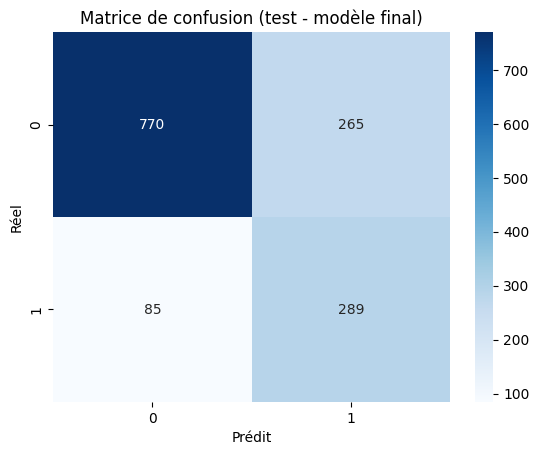

In [110]:
# Afficher la matrice de confusion
print("\nMatrice de confusion sur l'ensemble de test (modèle final) :")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion (test - modèle final)')
plt.show()

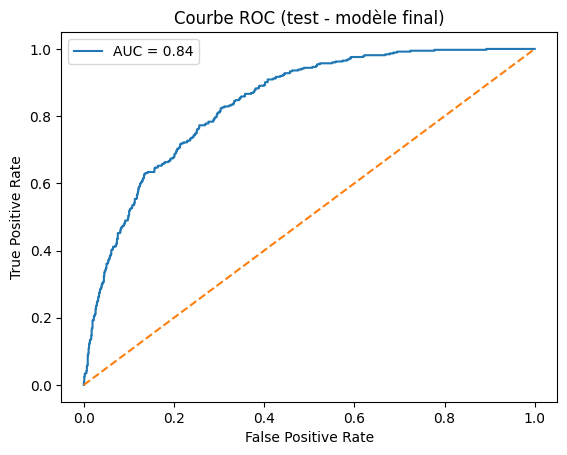

In [111]:
# Afficher la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC (test - modèle final)')
plt.legend()
plt.show()

In [112]:
# Afficher les features importantes (approximation)
# Note : Cette partie est une approximation car l'importance des features
# est plus complexe à déterminer dans un réseau de neurones.
# Ici, on regarde les poids de la première couche dense.
try:
    first_layer_weights = final_model.layers[1].get_weights()[0]
    feature_names = best_preprocessor.get_feature_names_out()
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(first_layer_weights).sum(axis=1)})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    print("\nImportance des features (approximation basée sur la première couche - modèle final) :")
    print(feature_importance.head(10))  # Afficher les 10 features les plus importantes
except:
    print("\nImpossible d'afficher l'importance des features (modèle trop simple ou trop complexe).")

# Affichage du meilleur résultat
print("\nMeilleur résultat trouvé :")
print(f"  AUC: {best_result['ROC_AUC_MLP']:.4f}")
print(f"  F1-score: {best_result['F1_MLP']:.4f}")
print(f"  Features supprimées: {best_result['features_dropped']}")
print(f"  Features conservées: {best_result['features_kept']}")


Impossible d'afficher l'importance des features (modèle trop simple ou trop complexe).

Meilleur résultat trouvé :
  AUC: 0.8388
  F1-score: 0.6166
  Features supprimées: StreamingMovies, StreamingTV, DeviceProtection, OnlineBackup
  Features conservées: gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, TechSupport, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges
